# Transfer Learning para Clasificación de Razas de Perros

En este notebook se implementa un enfoque de **Transfer Learning** utilizando una red neuronal convolucional preentrenada en **ImageNet**, adaptada al problema de **clasificación de razas de perros**.  
Se emplea un dataset de imágenes organizado por clases y se evalúa el desempeño del modelo mediante métricas y visualizaciones.


## Objetivo

Aplicar Transfer Learning usando un modelo CNN preentrenado, adaptándolo a un dataset de razas de perros mediante:
- Preprocesamiento de imágenes
- Entrenamiento con capas congeladas
- Fine-tuning del modelo
- Evaluación con métricas de clasificación multiclase


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import classification_report, confusion_matrix


## Dataset

Se utiliza el dataset **Dog Breeds** de Kaggle, el cual contiene imágenes organizadas en carpetas, donde cada carpeta representa una raza distinta de perro.


In [30]:
!pip install -q kaggle


In [31]:
from google.colab import files
files.upload()  # Subir kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ambergrijalba","key":"e2fc0dfeece8f48a88f8210942b92bea"}'}

In [32]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [33]:
!kaggle datasets download -d mohamedchahed/dog-breeds
!unzip -q dog-breeds.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
License(s): CC0-1.0
dog-breeds.zip: Skipping, found more recently modified local copy (use --force to force download)


## Preprocesamiento de Imágenes

Las imágenes se redimensionan y se aplican técnicas de **data augmentation** para mejorar la capacidad de generalización del modelo.


In [34]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "dog-breeds",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    "dog-breeds",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

NUM_CLASSES = train_generator.num_classes


Found 435 images belonging to 8 classes.
Found 106 images belonging to 8 classes.


## Modelo Base Preentrenado

Se utiliza **EfficientNetB0** con pesos entrenados en ImageNet, excluyendo la capa superior para adaptarlo al nuevo problema.


In [35]:
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=3)]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entrenamiento con capas congeladas


In [36]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.1510 - loss: 2.1207 - top_k_categorical_accuracy: 0.3687 - val_accuracy: 0.1509 - val_loss: 2.0743 - val_top_k_categorical_accuracy: 0.4340
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 861ms/step - accuracy: 0.1213 - loss: 2.0967 - top_k_categorical_accuracy: 0.4139 - val_accuracy: 0.1509 - val_loss: 2.0678 - val_top_k_categorical_accuracy: 0.4434
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 833ms/step - accuracy: 0.1401 - loss: 2.0745 - top_k_categorical_accuracy: 0.4335 - val_accuracy: 0.1509 - val_loss: 2.0766 - val_top_k_categorical_accuracy: 0.4340
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 844ms/step - accuracy: 0.1631 - loss: 2.0626 - top_k_categorical_accuracy: 0.4979 - val_accuracy: 0.1415 - val_loss: 2.0664 - val_top_k_categorical_accuracy: 0.4245
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 841ms/step - accuracy: 0.1079 - loss: 2.0842 - top_k_categorical_accuracy: 0.3707 - val_accuracy: 0.1415 - val_loss: 2.0703 - val_top

## Resultados del Entrenamiento


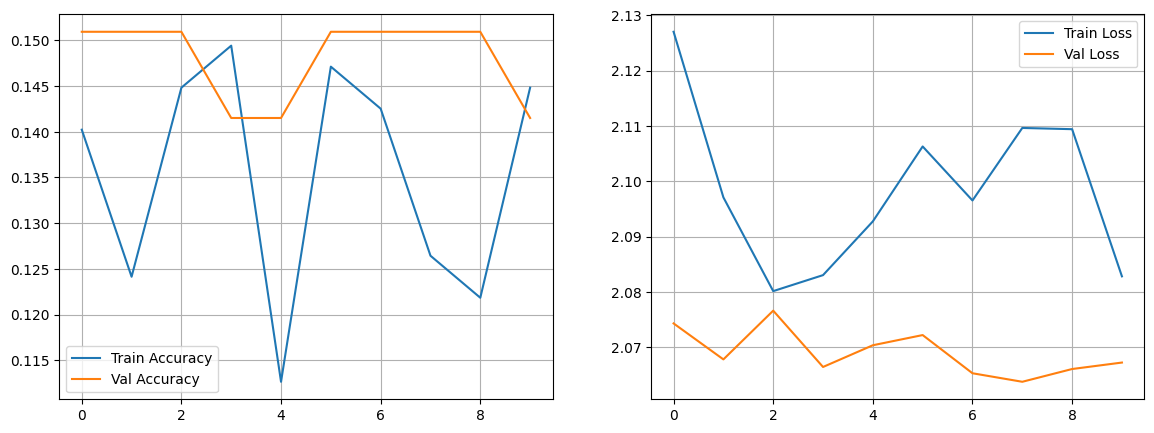

In [37]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.grid()

plt.show()


## Fine-Tuning del Modelo

Se descongelan parcialmente las capas superiores del modelo base y se reduce la tasa de aprendizaje.


In [38]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.TopKCategoricalAccuracy(k=3)]
)

history_ft = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.1139 - loss: 2.1184 - top_k_categorical_accuracy: 0.3896 - val_accuracy: 0.1415 - val_loss: 2.0679 - val_top_k_categorical_accuracy: 0.4340
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 837ms/step - accuracy: 0.1403 - loss: 2.1160 - top_k_categorical_accuracy: 0.3751 - val_accuracy: 0.1415 - val_loss: 2.0683 - val_top_k_categorical_accuracy: 0.4340
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 850ms/step - accuracy: 0.1481 - loss: 2.1158 - top_k_categorical_accuracy: 0.3585 - val_accuracy: 0.1415 - val_loss: 2.0685 - val_top_k_categorical_accuracy: 0.4340
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 836ms/step - accuracy: 0.1381 - loss: 2.0865 - top_k_categorical_accuracy: 0.4248 - val_accuracy: 0.1415 - val_loss: 2.0688 - val_top_k_categorical_accuracy: 0.4340
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 849ms/step - accuracy: 0.1162 - loss: 2.1018 - top_k_categorical_accuracy: 0.3768 - val_accuracy: 0.1415 - val_loss: 2.0689 - val_top

## Evaluación del Modelo


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


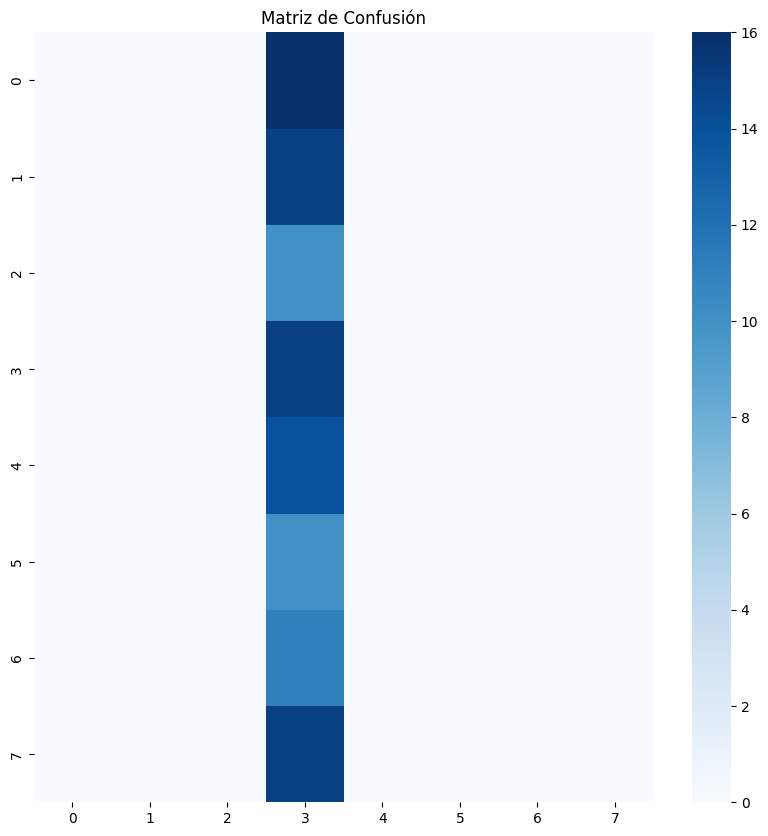

In [39]:
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()


In [40]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        10
           3       0.14      1.00      0.25        15
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        15

    accuracy                           0.14       106
   macro avg       0.02      0.12      0.03       106
weighted avg       0.02      0.14      0.04       106



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparación Visual de Predicciones

A continuación se muestran ejemplos de imágenes del conjunto de validación, comparando la **raza real** del perro con la **raza predicha** por el modelo entrenado.  
Esta visualización permite evaluar de forma cualitativa el desempeño del clasificador.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


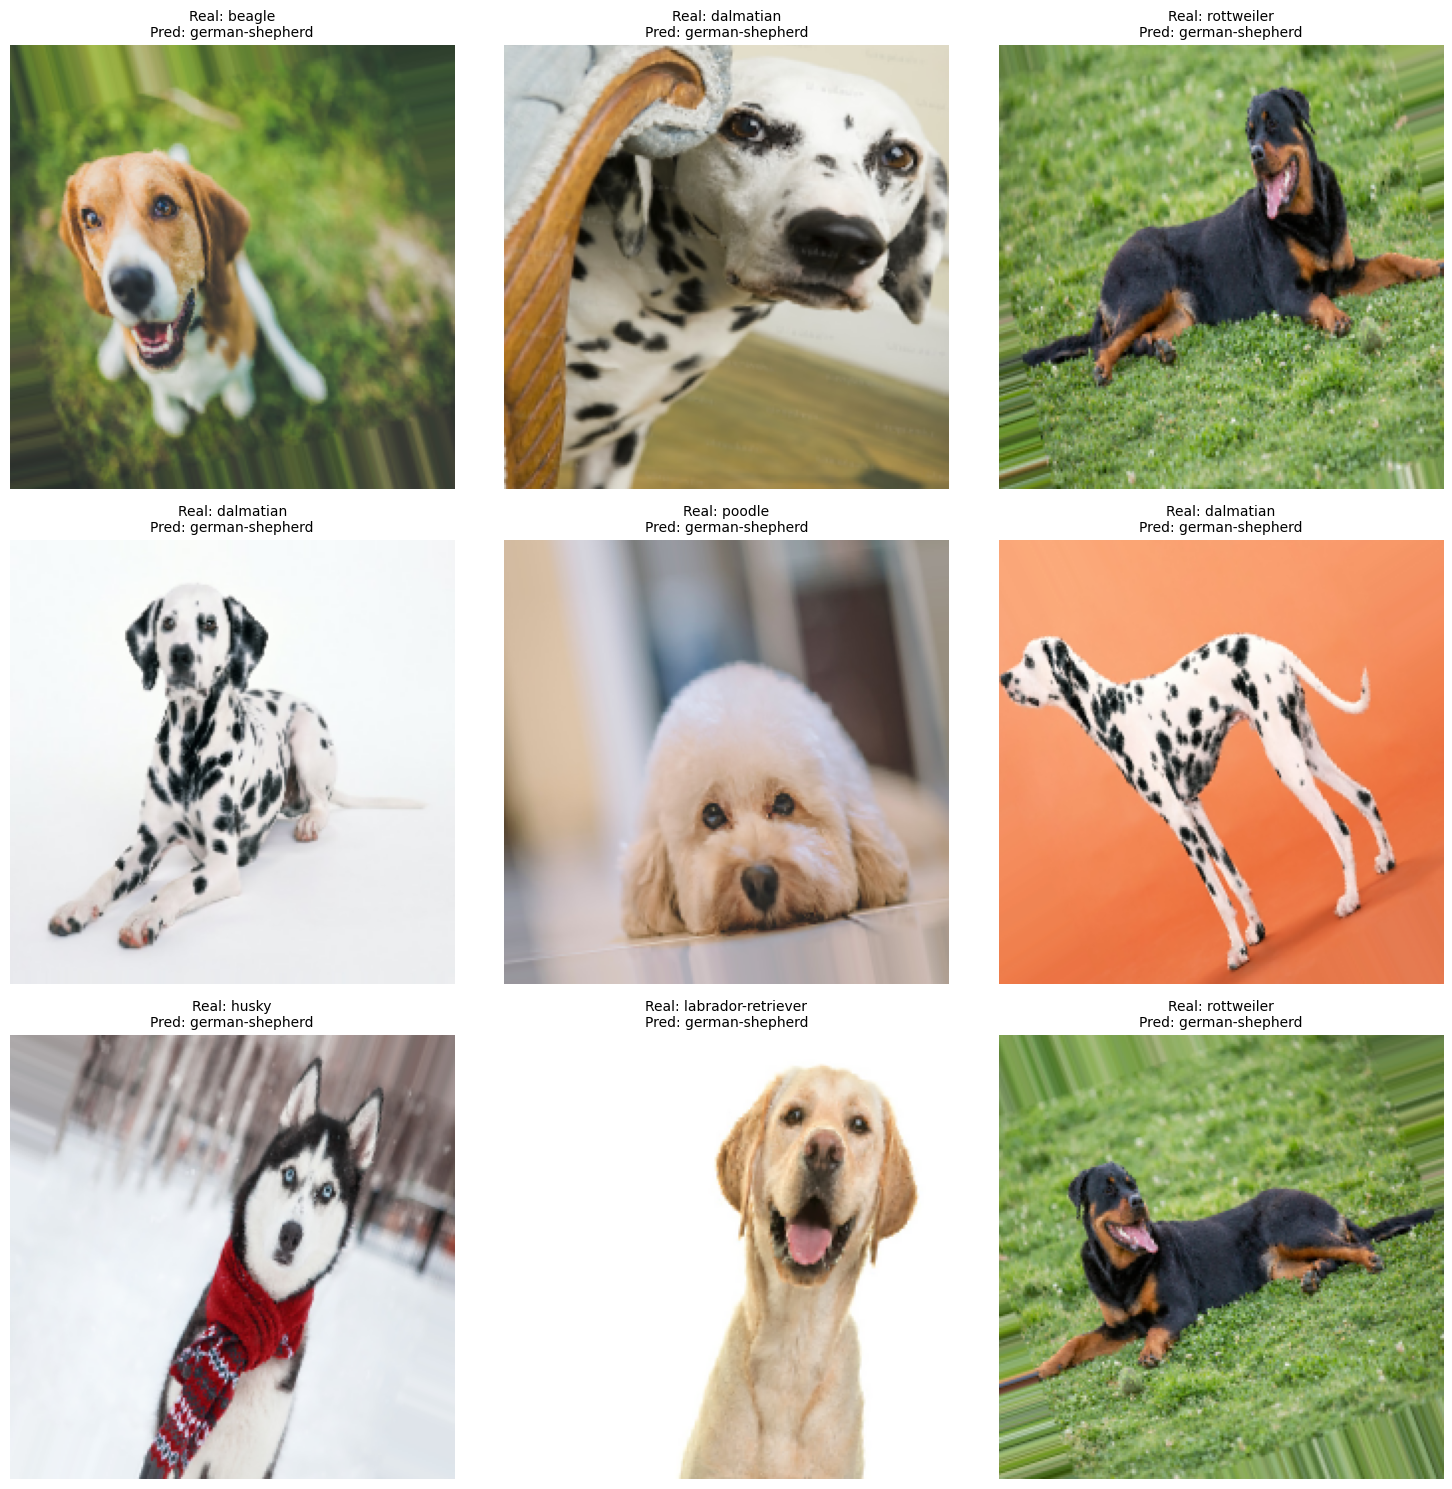

In [41]:
import random

# Obtener etiquetas de clases
class_names = list(train_generator.class_indices.keys())

# Seleccionar un batch aleatorio
images, labels = next(val_generator)

plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(3, 3, i + 1)

    img = images[i]
    true_label = class_names[np.argmax(labels[i])]

    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = class_names[np.argmax(pred)]

    plt.imshow(img)
    plt.title(f"Real: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Predicciones Top-3 por Imagen

Se muestran las tres razas con mayor probabilidad estimada por el modelo para cada imagen.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


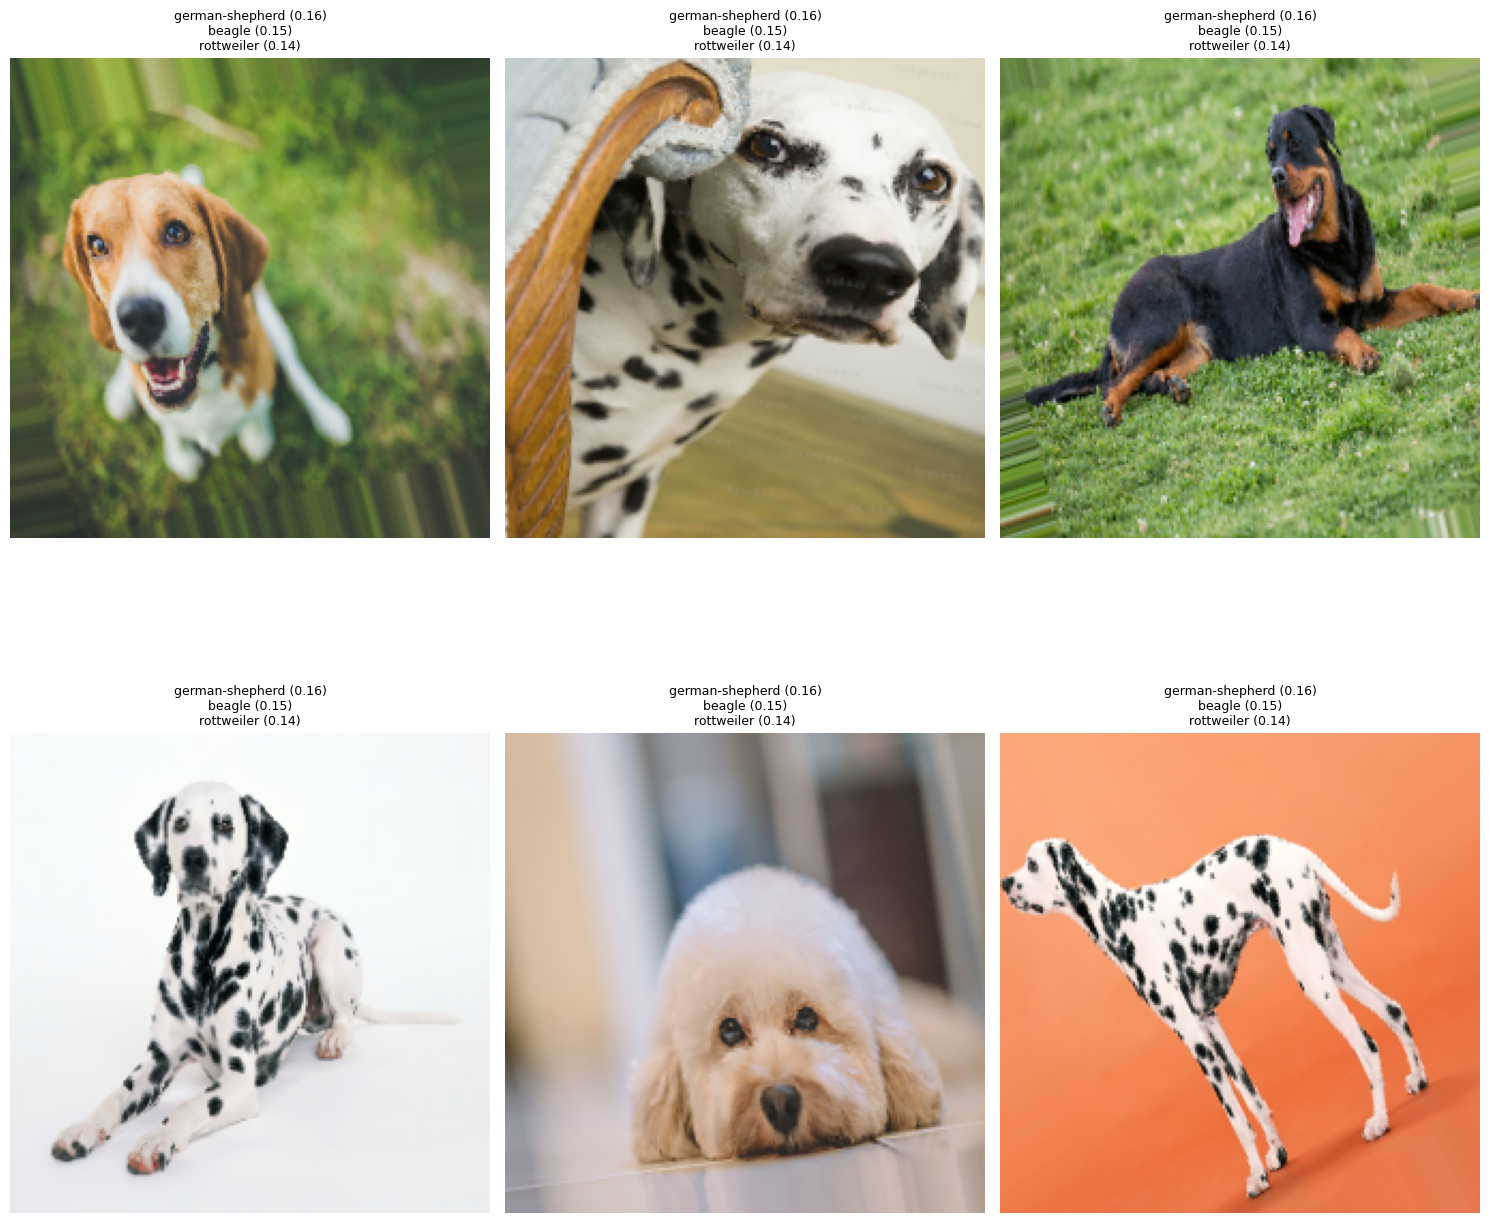

In [42]:
plt.figure(figsize=(15, 15))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    img = images[i]
    pred = model.predict(np.expand_dims(img, axis=0))[0]

    top3_idx = np.argsort(pred)[-3:][::-1]
    top3_labels = [class_names[j] for j in top3_idx]
    top3_probs = [pred[j] for j in top3_idx]

    plt.imshow(img)
    plt.title(
        f"{top3_labels[0]} ({top3_probs[0]:.2f})\n"
        f"{top3_labels[1]} ({top3_probs[1]:.2f})\n"
        f"{top3_labels[2]} ({top3_probs[2]:.2f})",
        fontsize=9
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


## Conclusiones

El uso de Transfer Learning permitió entrenar un modelo robusto para la clasificación de razas de perros con un conjunto de datos limitado. La utilización de un modelo preentrenado aceleró el proceso de aprendizaje y mejoró el desempeño del clasificador. El fine-tuning contribuyó a un ajuste más preciso del modelo, logrando mejores resultados en términos de accuracy y top-k accuracy.
